In [2]:
import torch

from semantic_sam.BaseModel import BaseModel
from semantic_sam import build_model
from utils.dist import init_distributed_mode
from utils.arguments import load_opt_from_config_file
from utils.constants import COCO_PANOPTIC_CLASSES

from tasks import interactive_infer_image_idino_m2m_auto, prompt_switch

/home/cyl/miniconda3/envs/Reconst/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
'''
build model
'''
ckpt="./weights/swinl_only_sam_many2many.pth"
cfgs={'T':"configs/semantic_sam_only_sa-1b_swinT.yaml",
      'L':"configs/semantic_sam_only_sa-1b_swinL.yaml"}

sam_cfg=cfgs['L']
opt = load_opt_from_config_file(sam_cfg)
model_sam = BaseModel(opt, build_model(opt)).from_pretrained(ckpt).eval().cuda()

/home/cyl/miniconda3/envs/Reconst/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541702/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
$UNUSED$ criterion.empty_weight, Ckpt Shape: torch.Size([2])


In [4]:
@torch.no_grad()
def inference(image,level=[0],*args, **kwargs):
    if level == 'All Prompt':
        level = [1, 2, 3, 4, 5, 6]
    else:
        level = [level.split(' ')[-1]]
    print(level)
    text_size, hole_scale, island_scale=640,100,100
    text, text_part, text_thresh='','','0.0'
    with torch.autocast(device_type='cuda', dtype=torch.float16):
        semantic=False
        model=model_sam
        a= interactive_infer_image_idino_m2m_auto(model, image,level,text,text_part,text_thresh,text_size,hole_scale,island_scale,semantic, *args, **kwargs)
        return a

from PIL import Image

def load_image_from_path(image_path):
    """
    Load an image from a file path and return it as a PIL Image object.
    
    Args:
        image_path (str): Path to the image file
        
    Returns:
        PIL.Image: Loaded image as a PIL Image object
    """
    try:
        # Open the image file
        img = Image.open(image_path)
        
        # Convert to RGB if the image is in RGBA mode (has transparency)
        if img.mode == 'RGBA':
            img = img.convert('RGB')
            
        return img
    except Exception as e:
        print(f"Error loading image from {image_path}: {e}")
        return None


In [7]:
example =  load_image_from_path("./examples/truck.jpg")

['2']


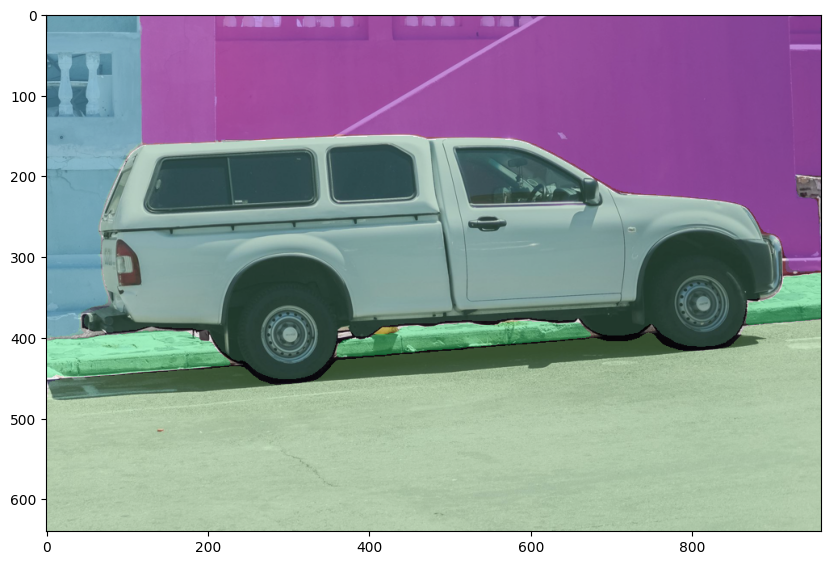

In [14]:
res = inference(image=example, level="2")